# Fully convolutional network for semantic segmentation

## Set up Google Colab

### Connect with Google drive 

In [1]:
from google.colab import drive 
drive.mount('/bdrive')

Mounted at /bdrive


### Go to the project directory

In [2]:
%cd ./../bdrive/My Drive/app/Hair-segmentation
%ls

/bdrive/My Drive/app/Hair-segmentation
data/  FCN.ipynb  images/


### Confirm that PIL works

In [0]:
from PIL import Image
Image.open(open("images/works.jpg","rb"))

In [0]:
# If PIL didn't work, run this cell and avoid the next
! which pillow
! pip uninstall pillow
! which pip
! /usr/local/bin/pip uninstall pip
! apt-get update
! apt-get install python3-pip
! pip3 install --upgrade pip
! pip3 install torch torchvision

### Install packages

In [3]:
!pip install torch torchvision

## Imports 

In [0]:
%matplotlib inline 


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.misc

import torch
import torch.nn as nn
import torch.functional as F
from torch import optim

from torchvision import models, datasets, transforms, utils
from torchvision.models.vgg import VGG
from torch.utils.data import Dataset

## Data

### Test with a Camvid dataset

In [0]:
class CamVid(Dataset):
  
  def __init__(self, csv_file, transform=None, n_classes=32):
    self.transforms = transform
    self.n_classes = n_classes
    self.data = pd.read_csv(csv_file)
  
  def __getitem__(self, index):
    image, label = self.data.iloc[index, 0], self.data.iloc[index, 1]
    image = Image.open("data/"+image).convert("RGB")
    label = Image.fromarray(np.load("data/"+label)).convert("RGB")
    
    if self.transforms is not None:
      image = self.transforms(image)
      label = self.transforms(label)
    
    # One-hot encoding 
    _, h, w = label.size()
    target = torch.zeros(self.n_classes, h, w)
    for c in range(self.n_classes):
      target[c][label[0] == c] = 1
      
    sample = {'x': image, 'y':target, 'l':label}     
    return sample 
  
  def __len__(self):
    return len(self.data) 

  
mean=[0.485, 0.456, 0.460]
std =[0.229, 0.224, 0.225]

train_transforms = transforms.Compose([transforms.Resize((480, 640)),
                                       transforms.RandomHorizontalFlip(0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, std)])


valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean, std)])

train_data = CamVid('./data/CamVid/train.csv', transform=train_transforms)
valid_data = CamVid('./data/CamVid/valid.csv', transform=valid_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=2)

### Visualize a single batch

0 torch.Size([4, 3, 480, 640]) torch.Size([4, 32, 480, 640])
1 torch.Size([4, 3, 480, 640]) torch.Size([4, 32, 480, 640])
2 torch.Size([4, 3, 480, 640]) torch.Size([4, 32, 480, 640])
3 torch.Size([4, 3, 480, 640]) torch.Size([4, 32, 480, 640])


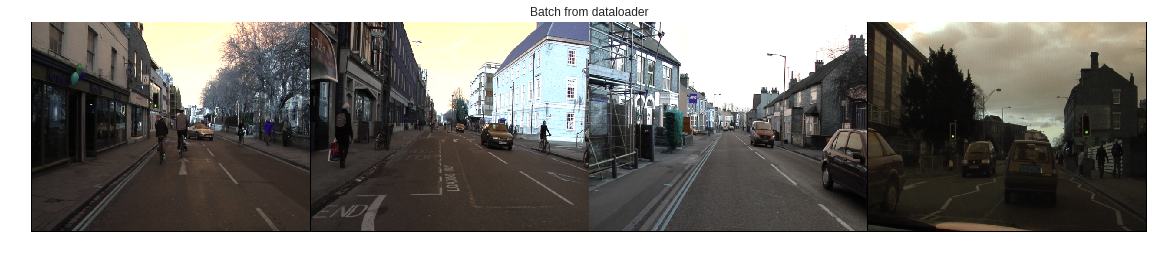

In [128]:
def show_batch(batch):
  
    img_batch = batch['x']
    
    img_batch[:,0,...].mul_(std[0]).add_(mean[0])
    img_batch[:,1,...].mul_(std[1]).add_(mean[1])
    img_batch[:,2,...].mul_(std[2]).add_(mean[2])
    
    image = np.clip(img_batch, 0, 1)
    
    grid = utils.make_grid(image)
    plt.imshow(grid.numpy()[::-1].transpose((1, 2, 0)))
    plt.title('Batch from dataloader')


for i, batch in enumerate(trainloader):
  print(i, batch['x'].size(), batch['y'].size())
  #  Observe the 4th batch 
  if i == 3:
    plt.figure()
    plt.rcParams['figure.figsize'] = [20.0, 13.0]
    show_batch(batch)
    plt.axis('off')
    plt.ioff()
    plt.show()
    break
    


## Model

### Encoder 

In [0]:
class VGG16(VGG):
  
  def __init__(self, cfg, ranges, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
    super().__init__(self.make_layers(cfg[model]))
    
    self.ranges = ranges[model]
        
    if pretrained:
      exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)
    if not requires_grad:
      for parameter in super().parameters():
        parameter.requires_grad = False
    if remove_fc: 
      del self.classifier
    if show_params:
      for name, parameter in self.named_parameters():
        print(name, parameter.size())
        
  def forward(self, x):
    output = {}
    
    # Get the output of each maxpooling layer (There are 5 in VGG) to create skip connections.
    for idx in range(len(self.ranges)):
      for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
        x = self.features[layer](x)
      output["pool%d"%(idx+1)] = x
    
    return output 
  
  def make_layers(self, cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
      if v == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
        if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
        else:
          layers += [conv2d, nn.ReLU(inplace=True)]
        in_channels = v
    return nn.Sequential(*layers)

### Decoder 

In [0]:
class FCN8s(nn.Module):
  
  def __init__(self, pretrained_model, n_classes):
    super().__init__()
    
    self.n_classes = n_classes
    self.pretrained_model = pretrained_model
    # Transposed convolutions (to upsampling previous layers)
    self.relu = nn.ReLU(inplace=True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128,  64, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d( 64,  32, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn5 = nn.BatchNorm2d(32)
    # Convolutional score layer (replace the FC layers)
    self.score = nn.Conv2d(32, n_classes, 1)
  
  def forward(self, x):
    x = self.pretrained_model(x)
    
    # Skip connections (connect the output of one layer to a non-adjacent layer)
    pool_5 = x['pool5']
    pool_4 = x['pool4']
    pool_3 = x['pool3']
    
    x = self.relu(self.deconv1(pool_5))
    x = self.bn1(x+pool_4)
    x = self.relu(self.deconv2(x))
    x = self.bn2(x+pool_3)
    x = self.bn3(self.relu(self.deconv3(x)))
    x = self.bn4(self.relu(self.deconv4(x)))
    x = self.bn5(self.relu(self.deconv5(x)))
    x = self.score(x)
    
    return x

In [0]:
ranges = {'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))}
cfg = {'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],}

###  Test output sizes

In [10]:
batch_size, n_classes, h, w = 10, 20, 160, 160

encoder = VGG16(cfg, ranges, requires_grad=True)
decoder = FCN8s(encoder, n_classes)

enc_input = torch.randn(batch_size, 3, 224, 224)
dec_input = torch.randn(batch_size, 3, h, w)

enc_output = encoder(enc_input)
dec_output = decoder(dec_input)

assert enc_output['pool5'].size() == torch.Size([batch_size, 512, 7, 7])
assert dec_output.size() == torch.Size([batch_size, n_classes, h, w])
print("Correct output sizes")

Correct output sizes


## Train model

### Test if the model works using a single batch

In [133]:
fcn = FCN8s(VGG16(cfg,ranges), n_classes)

criterion = nn.BCELoss()
optimizer = optim.SGD(fcn.parameters(), lr=0.01, momentum=0.9)

x = torch.randn(batch_size, 3, h, w)
y = torch.randn(batch_size, n_classes, h, w)
y = torch.tensor(y, requires_grad=False)

for i in range(10):
  optimizer.zero_grad()
  output = fcn(x)
  output = torch.sigmoid(output)
  loss = criterion(output, y)
  loss.backward()
  print("i: {}, loss: {:.5f}".format(i, loss.item()))
  optimizer.step()

i: 0, loss: 0.71130
i: 1, loss: 0.71111
i: 2, loss: 0.71076
i: 3, loss: 0.71026
i: 4, loss: 0.70964
i: 5, loss: 0.70888
i: 6, loss: 0.70802
i: 7, loss: 0.70707
i: 8, loss: 0.70604
i: 9, loss: 0.70493


### Set training parameters

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [0]:
# Define model
model = FCN8s(VGG16(cfg, ranges), 32)
model.to(device)

# Define training parameters
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
epochs = 1
print_every = 10

# Define scores
IoU_scores = np.zeros((epochs, 32))
pixel_scores = np.zeros(epochs)

### Check accuracy before training

In [0]:
def iou(y_hat, y):
  ious = []
  for c in range(n_classes):
    pred_inds = y_hat == c
    target_inds = y == c
    intersection = pred_inds[target_inds].sum()
    union = pred_inds.sum() + target_inds.sum() - intersection
    if union == 0:
      ious.append(float('nan')) # If there is no ground truth, do not include in evaluation
    else:
      ious.append(float(intersection) / max(union, 1))
  return ios

def pixel_accuracy(y_hat, y):
  correct = (y_hat == y).sum()
  total = (y == y).sum()
  return correct/total


def validation(model, validloader, criterion):
  ious = []
  pixels_accs = []
  for i, batch in enumerate(validloader):
    inputs, labels = batch['x'].to(device), batch['y'].to(device)
    output = model(inputs)
    output = output.data.cpu().numpy()
    
    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_classes).argmax(axis=1).reshape(N, h, w)
    
    target = batch['l'].cpu().numpy().reshape(N, h, w)
    for y_hat, y in zip(pred, target):
      ious.append(iou(y_hat, y))
      pixels_accs.append(pixel_accuracy(y_hat, y))
  # Calculate avergae IoU
  total_ious = np.array(ious).T #n_classes * validation len
  ious = np.nanmean(total_ious, axis=1)
  pixel_accs = np.array(pixel_accs).mean
  return pixel_accs, np.nanmean(ious), ious

### Train

In [18]:
for epoch in range(epochs):
  for i, batch in enumerate(trainloader):
    inputs, labels = batch['x'].to(device), batch['y'].to(device)
    optimizer.zero_grad()
    
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if i % print_every == 0:
      model.eval()
      with torch.no_grad():
        #paccuracy, meaniou, ious = validation(model, validloader, criterion)
        paccuracy, meaniou, ious = 0, 0, 0
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training loss: {:.4f}.. ".format(loss.item()),
              #"Pixel accuracy.. {}".format(paccuracy),
              #"Mean IoU.. {}".format(meaniou),
              #"IoUs.. {}".format(ious)
             )
      model.train()

Epoch: 1/1..  Training loss: 0.8060.. 
Epoch: 1/1..  Training loss: 0.6568.. 
Epoch: 1/1..  Training loss: 0.6104.. 
Epoch: 1/1..  Training loss: 0.5599.. 
Epoch: 1/1..  Training loss: 0.5075.. 
Epoch: 1/1..  Training loss: 0.4553.. 
Epoch: 1/1..  Training loss: 0.4052.. 
Epoch: 1/1..  Training loss: 0.3584.. 
Epoch: 1/1..  Training loss: 0.3158.. 
Epoch: 1/1..  Training loss: 0.2772.. 
Epoch: 1/1..  Training loss: 0.2432.. 
Epoch: 1/1..  Training loss: 0.2134.. 
Epoch: 1/1..  Training loss: 0.1874.. 
Epoch: 1/1..  Training loss: 0.1649.. 
Epoch: 1/1..  Training loss: 0.1454.. 
Epoch: 1/1..  Training loss: 0.1285.. 


## Save model

In [0]:
torch.save(model.state_dict(), "./fcn.pth")